## Covid-19 Vaccine Sentiment Analysis

In [ ]:
import numpy as np # Linear algebra
import pandas as pd # Data processing
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
plt.rc('figure',figsize=(17,13))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
import pandas as pd
import re

# Read the CSV file
f_data = pd.read_csv('vaccination_tweets.csv')

# Convert text to lowercase
f_data['text'] = f_data['text'].str.lower()

# Remove Twitter handlers
f_data['text'] = f_data['text'].apply(lambda x: re.sub('@[^\s]+', '', x))

# Remove hashtags
f_data['text'] = f_data['text'].apply(lambda x: re.sub('#[^\s]+', '', x))

# Remove URLs
f_data['text'] = f_data['text'].apply(lambda x: re.sub(r'https\S+', '', x))

# Remove all special characters
f_data['text'] = f_data['text'].apply(lambda x: ' '.join(re.findall(r'\w+', x)))

# Remove all single characters
f_data['text'] = f_data['text'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substitute multiple spaces with single space
f_data['text'] = f_data['text'].apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))


## Covid-19 Vaccine Sentiment Analysis

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as STA
import re

# Create SentimentIntensityAnalyzer object
sid = STA()

# Apply sentiment analysis to each text entry
f_data['sentiments'] = f_data['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+', x.lower()))))

# Extract sentiment scores and add a small value to avoid division by zero
f_data['Positive Sentiment'] = f_data['sentiments'].apply(lambda x: x['pos'] + 1e-6)
f_data['Neutral Sentiment'] = f_data['sentiments'].apply(lambda x: x['neu'] + 1e-6)
f_data['Negative Sentiment'] = f_data['sentiments'].apply(lambda x: x['neg'] + 1e-6)

# Drop the 'sentiments' column
f_data.drop(columns=['sentiments'], inplace=True)


## Exploratory Data Analysis

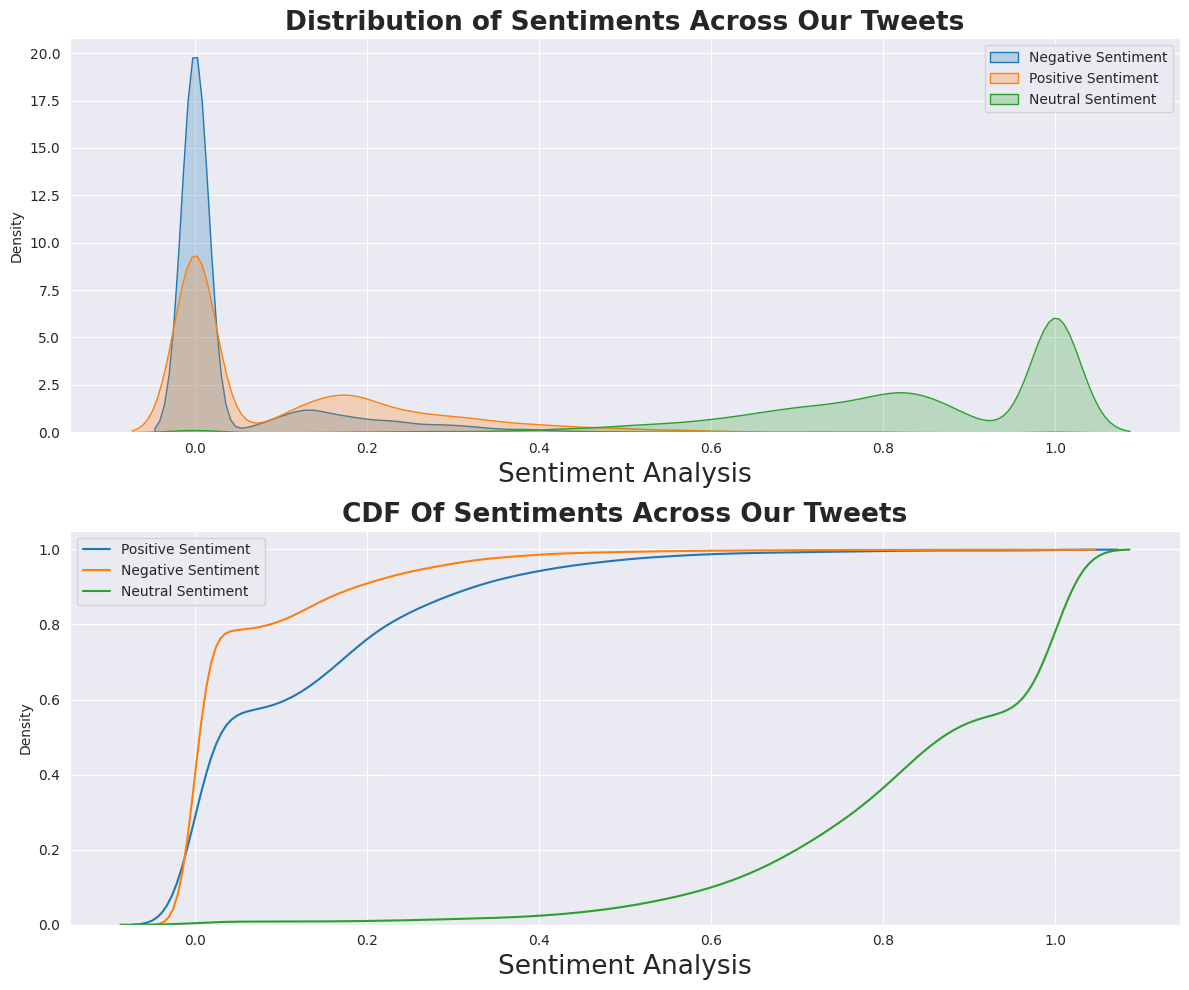

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

# Distribution of Sentiments Across Tweets
plt.subplot(2, 1, 1)
plt.title('Distribution of Sentiments Across Our Tweets', fontsize=19, fontweight='bold')
sns.kdeplot(f_data['Negative Sentiment'], fill=True, label='Negative Sentiment')
sns.kdeplot(f_data['Positive Sentiment'], fill=True, label='Positive Sentiment')
sns.kdeplot(f_data['Neutral Sentiment'], fill=True, label='Neutral Sentiment')
plt.xlabel('Sentiment Analysis', fontsize=19)
plt.legend()

# Cumulative Distribution Function (CDF) of Sentiments Across Tweets
plt.subplot(2, 1, 2)
plt.title('CDF Of Sentiments Across Our Tweets', fontsize=19, fontweight='bold')
sns.kdeplot(f_data['Positive Sentiment'], cumulative=True, label='Positive Sentiment')
sns.kdeplot(f_data['Negative Sentiment'], cumulative=True, label='Negative Sentiment')
sns.kdeplot(f_data['Neutral Sentiment'], cumulative=True, label='Neutral Sentiment')
plt.xlabel('Sentiment Analysis', fontsize=19)
plt.legend()

plt.tight_layout()
plt.show()


## Analyze Sentiments with Python


<ipython-input-10-b4ce38131f10>:22: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


<ipython-input-10-b4ce38131f10>:32: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.




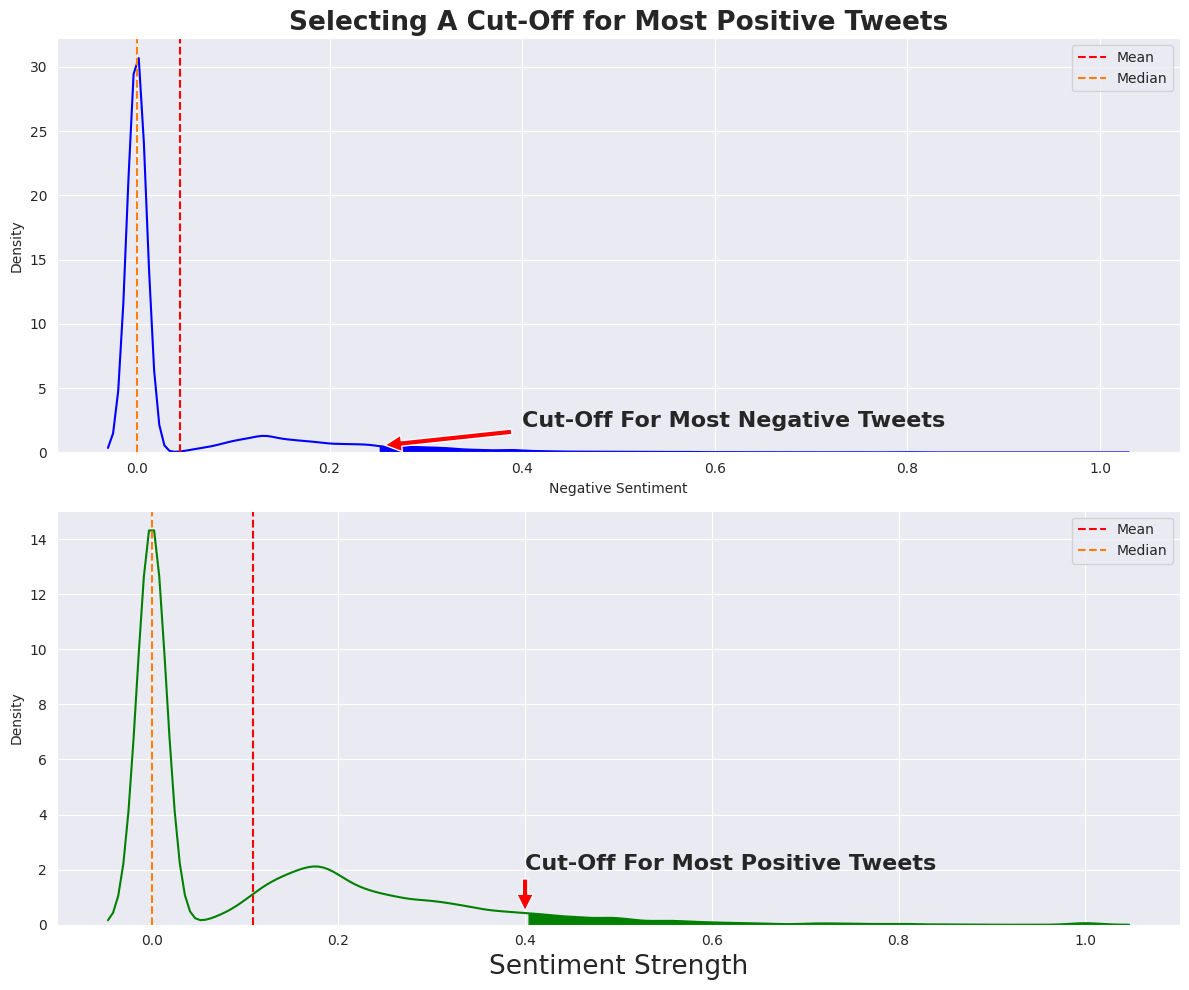

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sorting and Feature Engineering
f_data = f_data.sort_values(by=['date'])
ft_data = f_data.copy()
ft_data['date'] = pd.to_datetime(ft_data['date']).dt.date

ft_data['year'] = pd.DatetimeIndex(ft_data['date']).year
ft_data['month'] = pd.DatetimeIndex(ft_data['date']).month
ft_data['day'] = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year'] = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter'] = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season'] = ft_data['month'] % 12 // 3 + 1

plt.figure(figsize=(12, 10))

# Selecting A Cut-Off for Most Positive Tweets
plt.subplot(2, 1, 1)
plt.title('Selecting A Cut-Off for Most Positive Tweets', fontsize=19, fontweight='bold')

ax0 = sns.kdeplot(f_data['Negative Sentiment'], bw=0.1, color='blue')
kde_x, kde_y = ax0.lines[0].get_data()
ax0.fill_between(kde_x, kde_y, where=(kde_x > 0.25), interpolate=True, color='blue')
plt.annotate('Cut-Off For Most Negative Tweets', xy=(0.25, 0.5), xytext=(0.4, 2),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=16, fontweight='bold')
ax0.axvline(f_data['Negative Sentiment'].mean(), color='r', linestyle='--', label='Mean')
ax0.axvline(f_data['Negative Sentiment'].median(), color='tab:orange', linestyle='--', label='Median')
plt.legend()

plt.subplot(2, 1, 2)
ax1 = sns.kdeplot(f_data['Positive Sentiment'], bw=0.1, color='green')
plt.annotate('Cut-Off For Most Positive Tweets', xy=(0.4, 0.43), xytext=(0.4, 2),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=16, fontweight='bold')
kde_x, kde_y = ax1.lines[0].get_data()
ax1.fill_between(kde_x, kde_y, where=(kde_x > 0.4), interpolate=True, color='green')
ax1.set_xlabel('Sentiment Strength', fontsize=19)
ax1.axvline(f_data['Positive Sentiment'].mean(), color='r', linestyle='--', label='Mean')
ax1.axvline(f_data['Positive Sentiment'].median(), color='tab:orange', linestyle='--', label='Median')
plt.legend()

plt.tight_layout()
plt.show()


## Visualize the most negative and the most positive sentiments

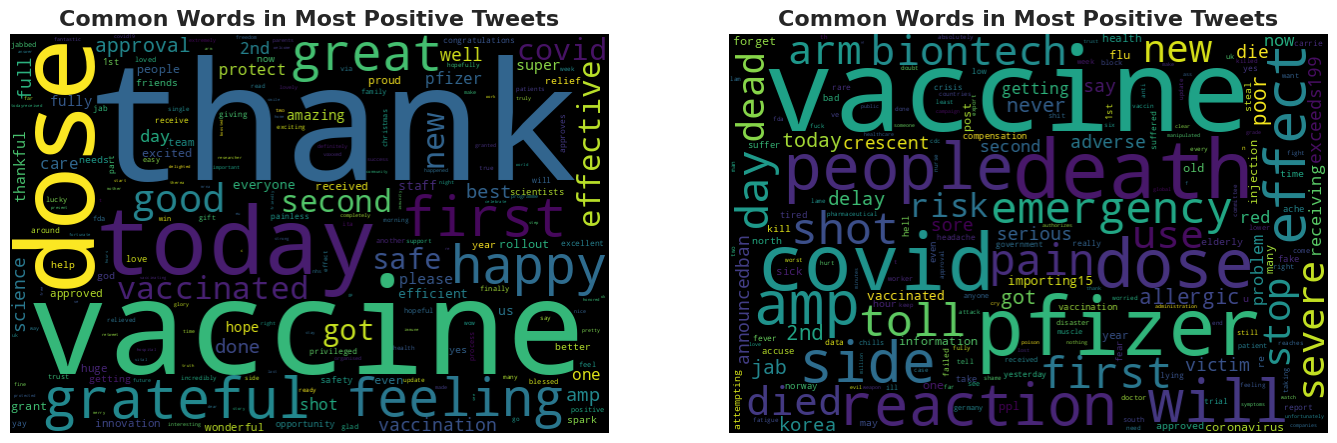

In [13]:
Most_Positive = f_data[f_data['Positive Sentiment'].between(0.4,1)]
Most_Negative = f_data[f_data['Negative Sentiment'].between(0.25,1)]

Most_Positive_text = ' '.join(Most_Positive.text)
Most_Negative_text = ' '.join(Most_Negative.text)

pwc = WordCloud(width=600,height=400,collocations = False).generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False).generate(Most_Negative_text)

plt.subplot(1,2,1)
plt.title('Common Words in Most Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Common Words in Most Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

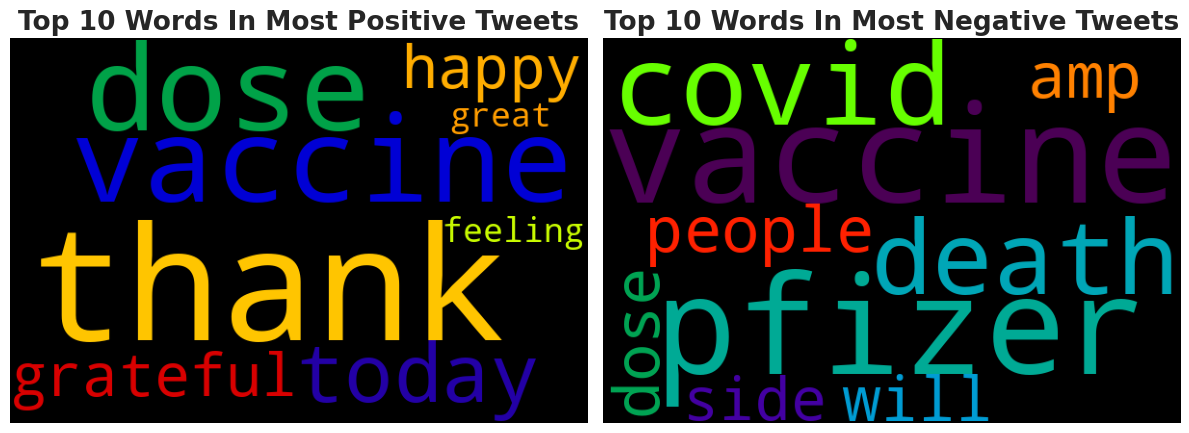

In [16]:
l_t = Most_Positive_text

w1_dict = dict()
for word in l_t.split():
    w = word.strip()
    if w in STOPWORDS:
        continue
    else:
        w1_dict[w] = w1_dict.get(w, 0) + 1

w1_dict = {k: v for k, v in sorted(w1_dict.items(), key=lambda item: item[1], reverse=True)}

l_t = Most_Negative_text

w2_dict = dict()
for word in l_t.split():
    w = word.strip()
    if w in STOPWORDS:
        continue
    else:
        w2_dict[w] = w2_dict.get(w, 0) + 1

w2_dict = {k: v for k, v in sorted(w2_dict.items(), key=lambda item: item[1], reverse=True)}

top_10_pos = list(w1_dict.keys())[:10]
top_10_neg = list(w2_dict.keys())[:10]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
w_c = WordCloud(width=600, height=400, collocations=False, colormap='nipy_spectral').generate(' '.join(top_10_pos))
plt.title('Top 10 Words In Most Positive Tweets', fontsize=19, fontweight='bold')
plt.imshow(w_c)
plt.axis('off')

plt.subplot(1, 2, 2)
w_c = WordCloud(width=600, height=400, collocations=False, colormap='nipy_spectral').generate(' '.join(top_10_neg))
plt.title('Top 10 Words In Most Negative Tweets', fontsize=19, fontweight='bold')
plt.imshow(w_c)
plt.axis('off')

plt.tight_layout()
plt.show()
